# Visualizing the training of Convolutional Neural Networks (with keras)

## Imports: numpy and matplotlib and keras

In [1]:
# keras: Squesntial is the neural-network class, Dense is
# the standard network layer
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300 # High resolution display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colotbars:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display
# (very simple animation)
from IPython.display import clear_output
from time import sleep

In [2]:
# visualization routines:

def visualize_CNN_training(network,
                               image_generator, resolution,
                    steps=100, batchsize=10,
                              visualize_nsteps=1, plot_img_pixels=3,
                          plot_img_cols=10,
                          plot_img_rows=5,
                          show_intermediate_layers=True):
    """
    Visualize the training of a (2D) convolutional neural network autoencoder.
    
    network is the network that you have defined using keras.
    
    'resolution' (called M below) is the image resolution in pixels
    
    image_generator is the name of a function that
    is called like
        image_generator(batchsize,x,y)
    and which has to return an array of shape
        [batchsize,M,M]
    that contains randomly generated MxM images (e.g. randomly
    placed circles or whatever you want to consider). The
    MxM arrays x and y are already filled with coordinates between -1 and 1.
    
    An example that returns images of randomly placed circles:
    
    def my_generator(batchsize,x,y):
        R=np.random.uniform(size=batchsize)
        x0=np.random.uniform(size=batchsize,low=-1,high=1)
        y0=np.random.uniform(size=batchsize,low=-1,high=1)
        return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )

   
    steps is the number of training steps
    
    batchsize is the number of samples per training step
            
    visualize_n_steps>1 means skip some steps before
    visualizing again (can speed up things)
    
    show_intermediate_layers==True means show the intermediate activations.
    Otherwise show the weights!
    
    These are always shown in the upper left corner, as a tiled image,
    whose properties are determined by:
        plot_img_pixels: the resolution for each of the image tiles
        plot_img_cols  : the number of columns of images
        plot_img_rows  : the number of rows of images
    Images (activations or weights) that are larger will be cut off.
    If there are more images than fit, the rest will be left out.
    The lowest layer starts in the bottom left. For activations, for
    each layer one runs through all the channels, and then the images
    for the next layer will start. Likewise for weights.
    """
    global y_target # allow access to target from outside
    
    M = resolution
        
    vals = np.linspace(-1,1,M)
    x,y = np.meshgrid(vals,vals)
    
    y_test = np.zeros([1,M,M,1])
    y_test[:,:,:,0] = image_generator(1,x,y)
    
    y_in = np.zeros([batchsize,M,M,1])

    costs = np.zeros(steps)
    extractor = get_layer_activation_extractor(network)
    
    for j in range(steps):
        # produce samples:
        y_in[:,:,:,0] = image_generator(batchsize,x,y)
        y_target = np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        costs[j] = network.train_on_batch(y_in,y_target)
        
        # now visualize the updated network:
        if j % visualize_nsteps == 0:
            clear_output(wait = True) # for animation
            if j > 10:
                cost_max = np.average(costs[0:j]) * 1.5
            else:
                cost_max = costs[0]
            
            # nice layout (needs matplotlib v3)
            fig = plt.figure(constrained_layout = True, figsize = (8,4))
            gs = fig.add_gridspec(ncols = 8, nrows = 4)
            filter_plot = fig.add_subplot(gs[0:3, 0:4])
            cost_plot = fig.add_subplot(gs[3, 0:4])
            test_in_plot = fig.add_subplot(gs[0:2, 4:6])
            test_out_plot = fig.add_subplot(gs[0:2, 6:8])

            cost_plot.plot(costs)
            cost_plot.set_ylim([0, cost_max])
            
            # test the network on a fixed test image!
            y_test_out = network.predict_on_batch(y_test)
            test_in_plot.imshow(y_test[0, :, :, 0], origin = 'lower')
            test_out_plot.imshow(y_test_out[0, :, :, 0], origin='lower')
            test_in_plot.axis('off')
            test_out_plot.axis('off')
            
            if show_intermediate_layers:
                features = extractor(y_test)
                n1 = 0; n2 = 0
                max_n1 = plot_img_rows
                max_n2 = plot_img_cols
                pix = plot_img_pixels
                img = np.full([(pix + 1) * max_n1, (pix + 1) * max_n2], 1.0)
                for feature in features:
                    for m in range(feature.shape[-1]):
                        w = feature[0,:,:,m]
                        ws = np.shape(w)
                        if n1 < max_n1 and n2 < max_n2:
                            W = np.zeros([pix, pix])
                            if ws[0] < pix:
                                W[0:ws[0], 0:ws[0]] = w[:,:]
                            else:
                                W[:,:] = w[0:pix, 0:pix]                            
                            img[n1 * (pix+1):(n1+1) * (pix+1)-1, n2 * (pix+1):(n2+1) * (pix+1)-1] = W
                            n2 += 1
                            if n2 >= max_n2:
                                n2 = 0
                                n1 += 1                
            else: # rather, we want the weights! (filters)
                n1 = 0; n2 = 0
                max_n1 = plot_img_rows
                max_n2 = plot_img_cols
                pix = plot_img_pixels
                img = np.zeros([(pix + 1) * max_n1, (pix + 1) * max_n2])
                for ly in network.layers:
                    w = ly.get_weights()
                    if w != []:
                        w = w[0]
                        ws = np.shape(w)
                        for k1 in range(ws[2]):
                            for k2 in range(ws[3]):
                                if n1 < max_n1 and n2 < max_n2:
                                    W = np.zeros([pix, pix])
                                    if ws[0] < pix:
                                        W[0:ws[0], 0:ws[0]] = w[:, :, k1, k2]
                                    else:
                                        W[:,:] = w[0:pix, 0:pix, k1, k2]                            
                                    img[n1 * (pix+1):(n1+1) * (pix+1)-1, n2 * (pix+1):(n2+1) * (pix+1)-1]=W
                                    n2 += 1
                                    if n2 >= max_n2:
                                        n2 = 0
                                        n1 += 1
            filter_plot.imshow(img, origin = 'lower')
            filter_plot.axis('off')
            plt.show()
    print("Final cost value (averaged over last 50 batches): ", np.average(costs[-50:]))



In [3]:
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize, pixels, pixels, channels).
    After a call to the visualization routine, y_target will contain 
    the last set of training images, so you could fed those in here.
    """
    layer_features = get_layer_activations(network, y_in)
    for idx, feature in enumerate(layer_features):
        s = np.shape(feature)
        print('Layer ' + str(idx) + ': ' + str(s[1] * s[2] * s[3]) + ' neurons / ', s)

In [4]:
def get_layer_activation_extractor(network):
    return(Model(inputs = network.inputs,
                outputs = [layer.output for layer in network.layers]))

In [5]:
def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor = get_layer_activation_extractor(network)
    layer_features = extractor(y_in)
    return (layer_features)

## Example 1: Reproducing randomly placed circles

In [6]:
def my_generator(batchsize, x, y):
    R = np.random.uniform(size = batchsize)
    x0 = np.random.uniform(size = batchsize, low = -1, high = 1)
    y0 = np.random.uniform(size = batchsize, low = -1, high = 1)
    return ( 1.0 * ((x[None, :, :] - x0[:, None, None])**2 + (y[None, :, :] - y0[:, None, None])**2 < R[:, None, None]**2) )

In [7]:
Net = Sequential()
# 3x3 kernel size, 10 channels in first hidden layer:
Net.add(Conv2D(filters = 10, kernel_size = (3, 3), input_shape = (None, None, 1),
              activation = 'sigmoid', padding = 'same'))
Net.add(BatchNormalization())
# 3x3 kernel size, only 1 channel in last hidden layer:
Net.add(Conv2D(filters = 1, kernel_size = (3, 3), 
               activation = 'linear', padding = 'same'))
Net.add(BatchNormalization())
Net.compile(loss = 'mean_squared_error',
           optimizer = 'adam')

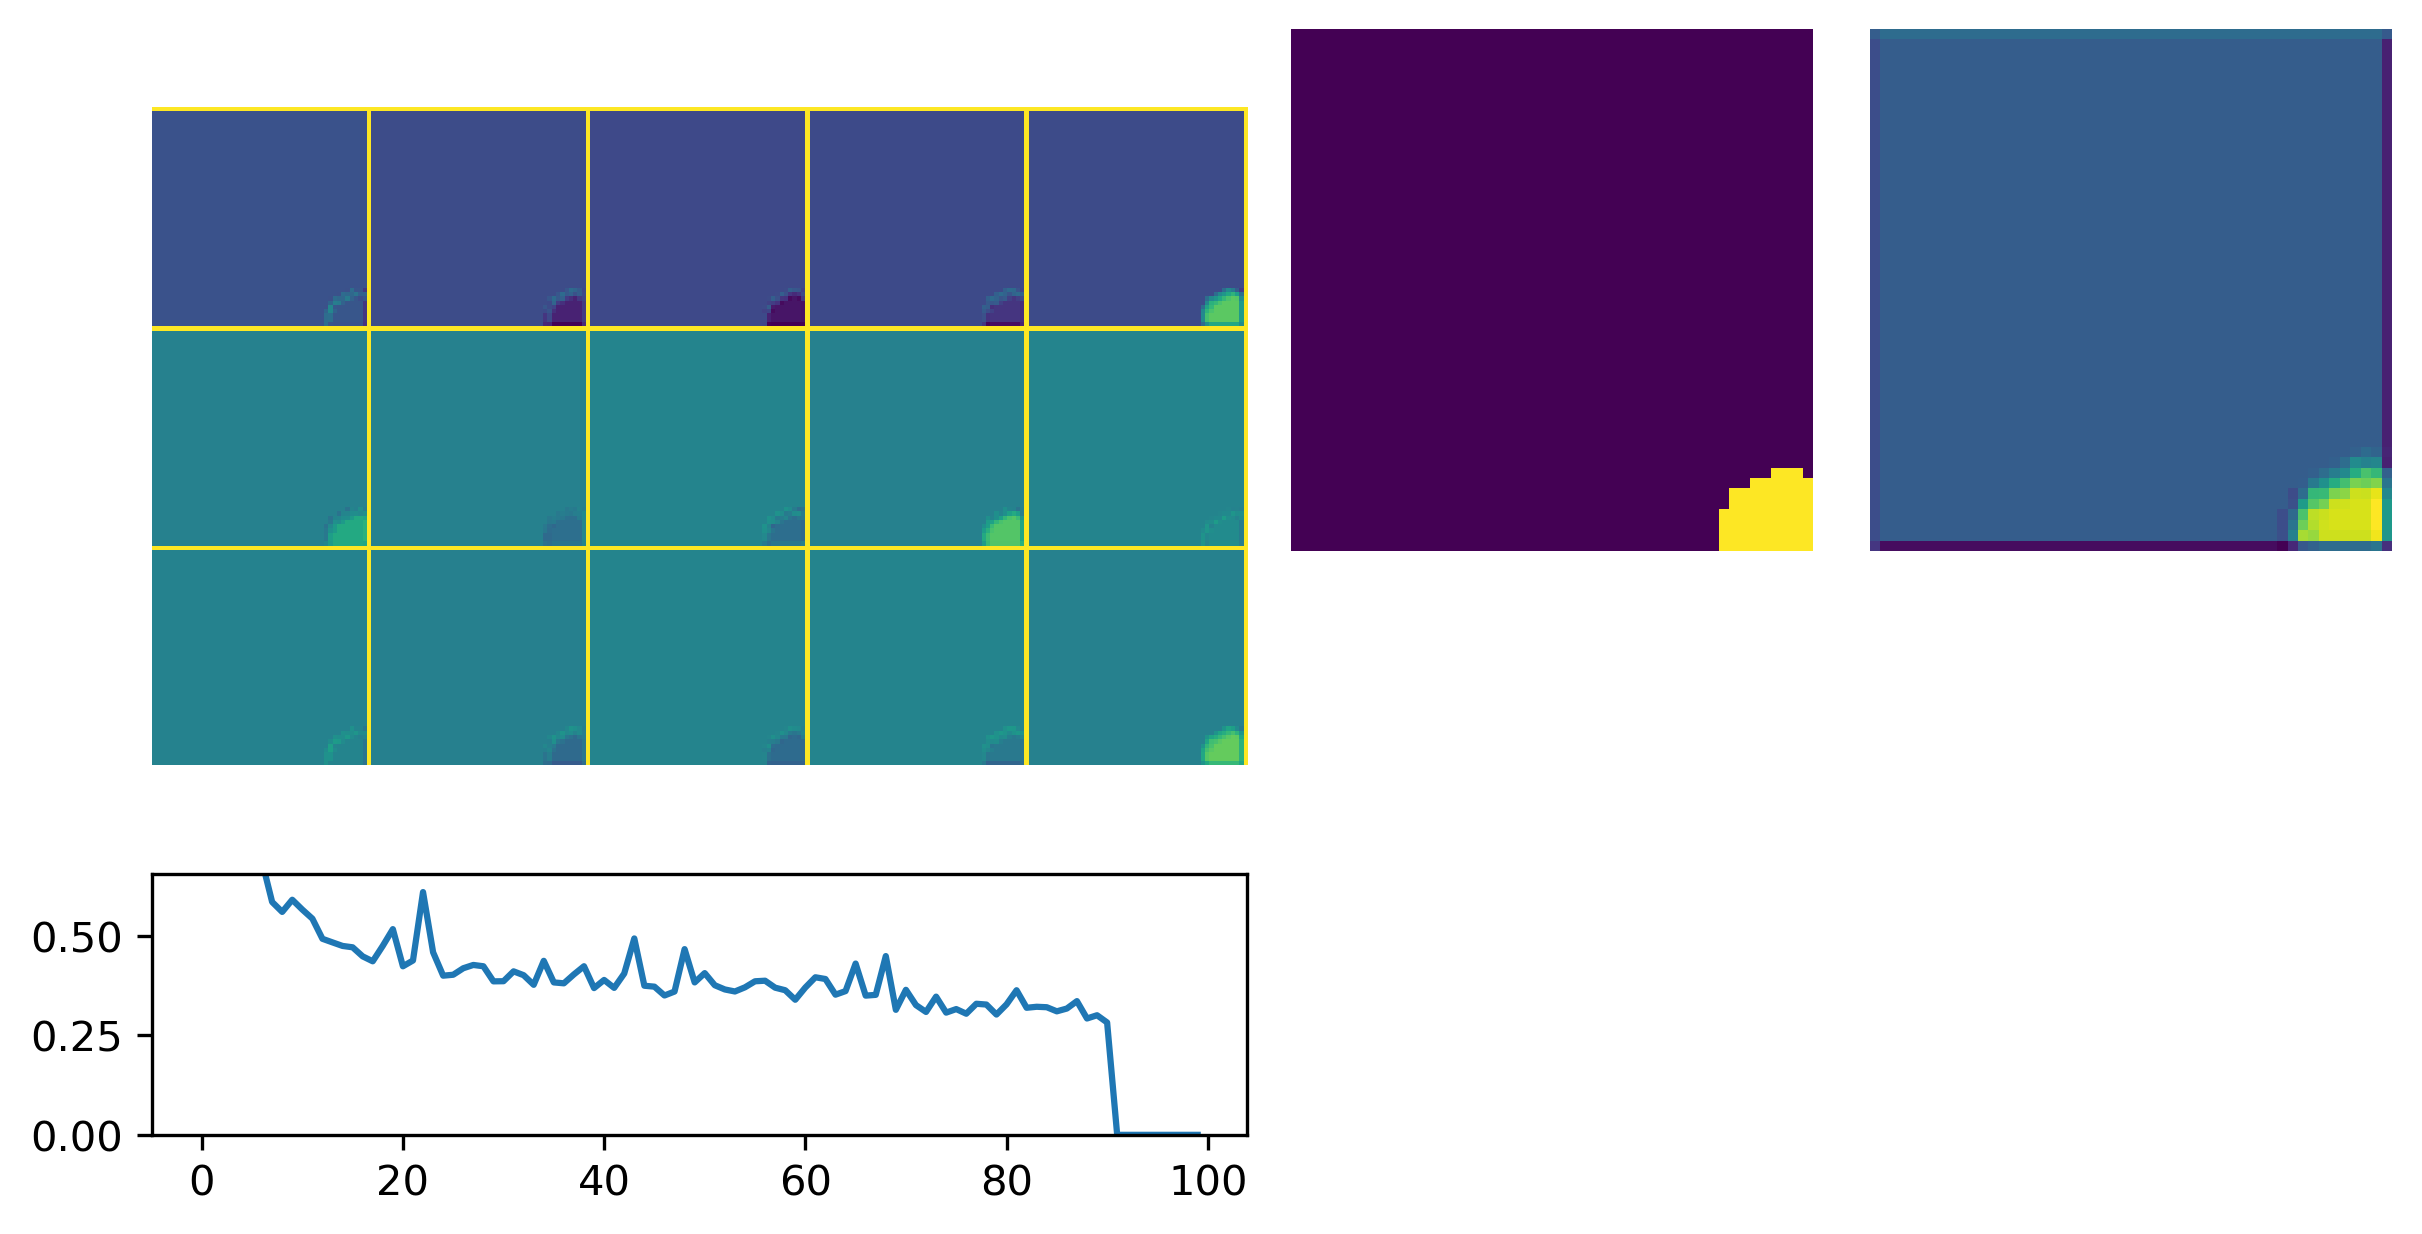

Final cost value (averaged over last 50 batches):  0.3451050287485123


In [8]:
visualize_CNN_training(Net, my_generator, 50,
                      steps = 100, batchsize = 10,
                      visualize_nsteps = 10,
                      plot_img_pixels = 50, plot_img_rows = 3, plot_img_cols = 5)

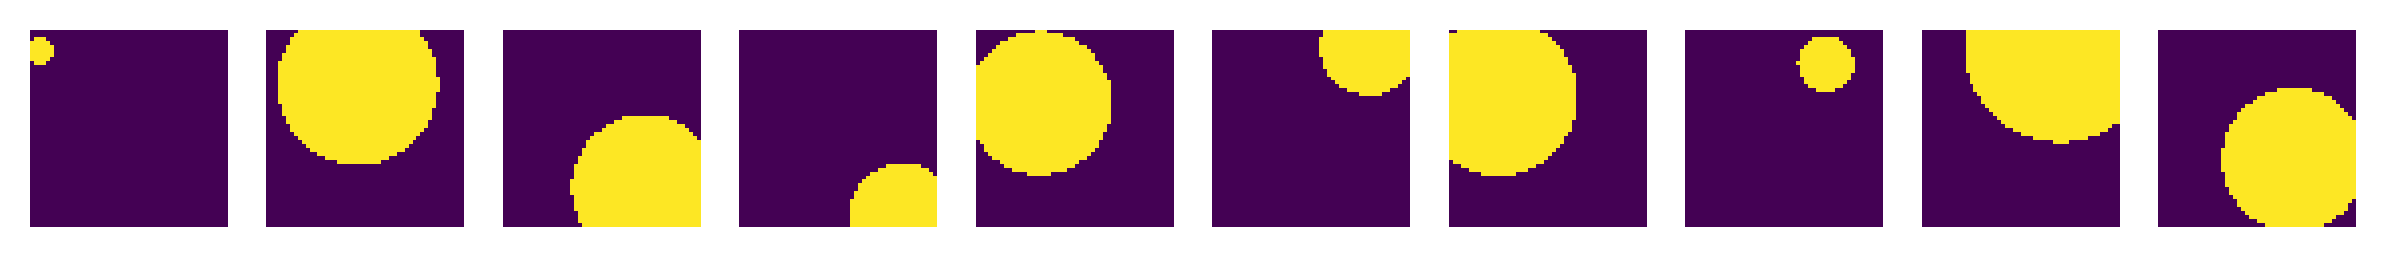

In [9]:
# show the typical training images (these are available
# in the global variable y_target after calling the visualization routine)
fig, ax = plt.subplots(ncols = 10, nrows = 1, figsize = (10, 1))
for j in range(10):
    ax[j].imshow(y_target[j, :, :, 0], origin = 'lower') # the last training images...
    ax[j].axis('off')
plt.show()

## Example 2: Reproducing randomly placed circles with a true autoencoder

In [10]:
def my_generator(batchsize, x, y):
    R = np.random.uniform(size = batchsize)
    x0 = np.random.uniform(size = batchsize, low = -1, high = 1)
    y0 = np.random.uniform(size = batchsize, low = -1, high = 1)
    return ( 1.0 * ((x[None, :, :] - x0[:, None, None])** 2 + (y[None, :, :] - y0[:, None, None])**2 < R[:, None, None]**2) )

In [14]:
Net = Sequential()
# 5x5 kernel size, 4 channels in first hidden layer:
Net.add(Conv2D(filters = 4, kernel_size = (5, 5), input_shape = (None, None, 1),
              activation = 'sigmoid', padding = 'same'))
#Net.add(BatchNormalization())
Net.add(AveragePooling2D(pool_size = (3, 3), padding = 'same')) # down
Net.add(Conv2D(filters = 4, kernel_size = (5, 5),
              activation = 'sigmoid', padding = 'same'))
#Net.add(BatchNormalization())
Net.add(AveragePooling2D(pool_size = (3, 3), padding = 'same')) # down
Net.add(Conv2D(filters = 1, kernel_size = (3, 3),
              activation = 'sigmoid', padding = 'same'))
#Net.add(BatchNormalization())
Net.add(UpSampling2D(size = (3, 3))) # up
Net.add(Conv2D(filters = 4, kernel_size = (5, 5),
              activation = 'sigmoid', padding = 'same'))
#Net.add(BatchNormalization())
Net.add(UpSampling2D(size = (3, 3))) # up
Net.add(Conv2D(filters = 1, kernel_size = (3, 3), 
               activation = 'linear', padding = 'same'))
#Net.add(BatchNormalization())
Net.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [15]:
Net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d_2 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 4)     404       
_________________________________________________________________
average_pooling2d_3 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 1)     37        
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, None, None, 1)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 4)    

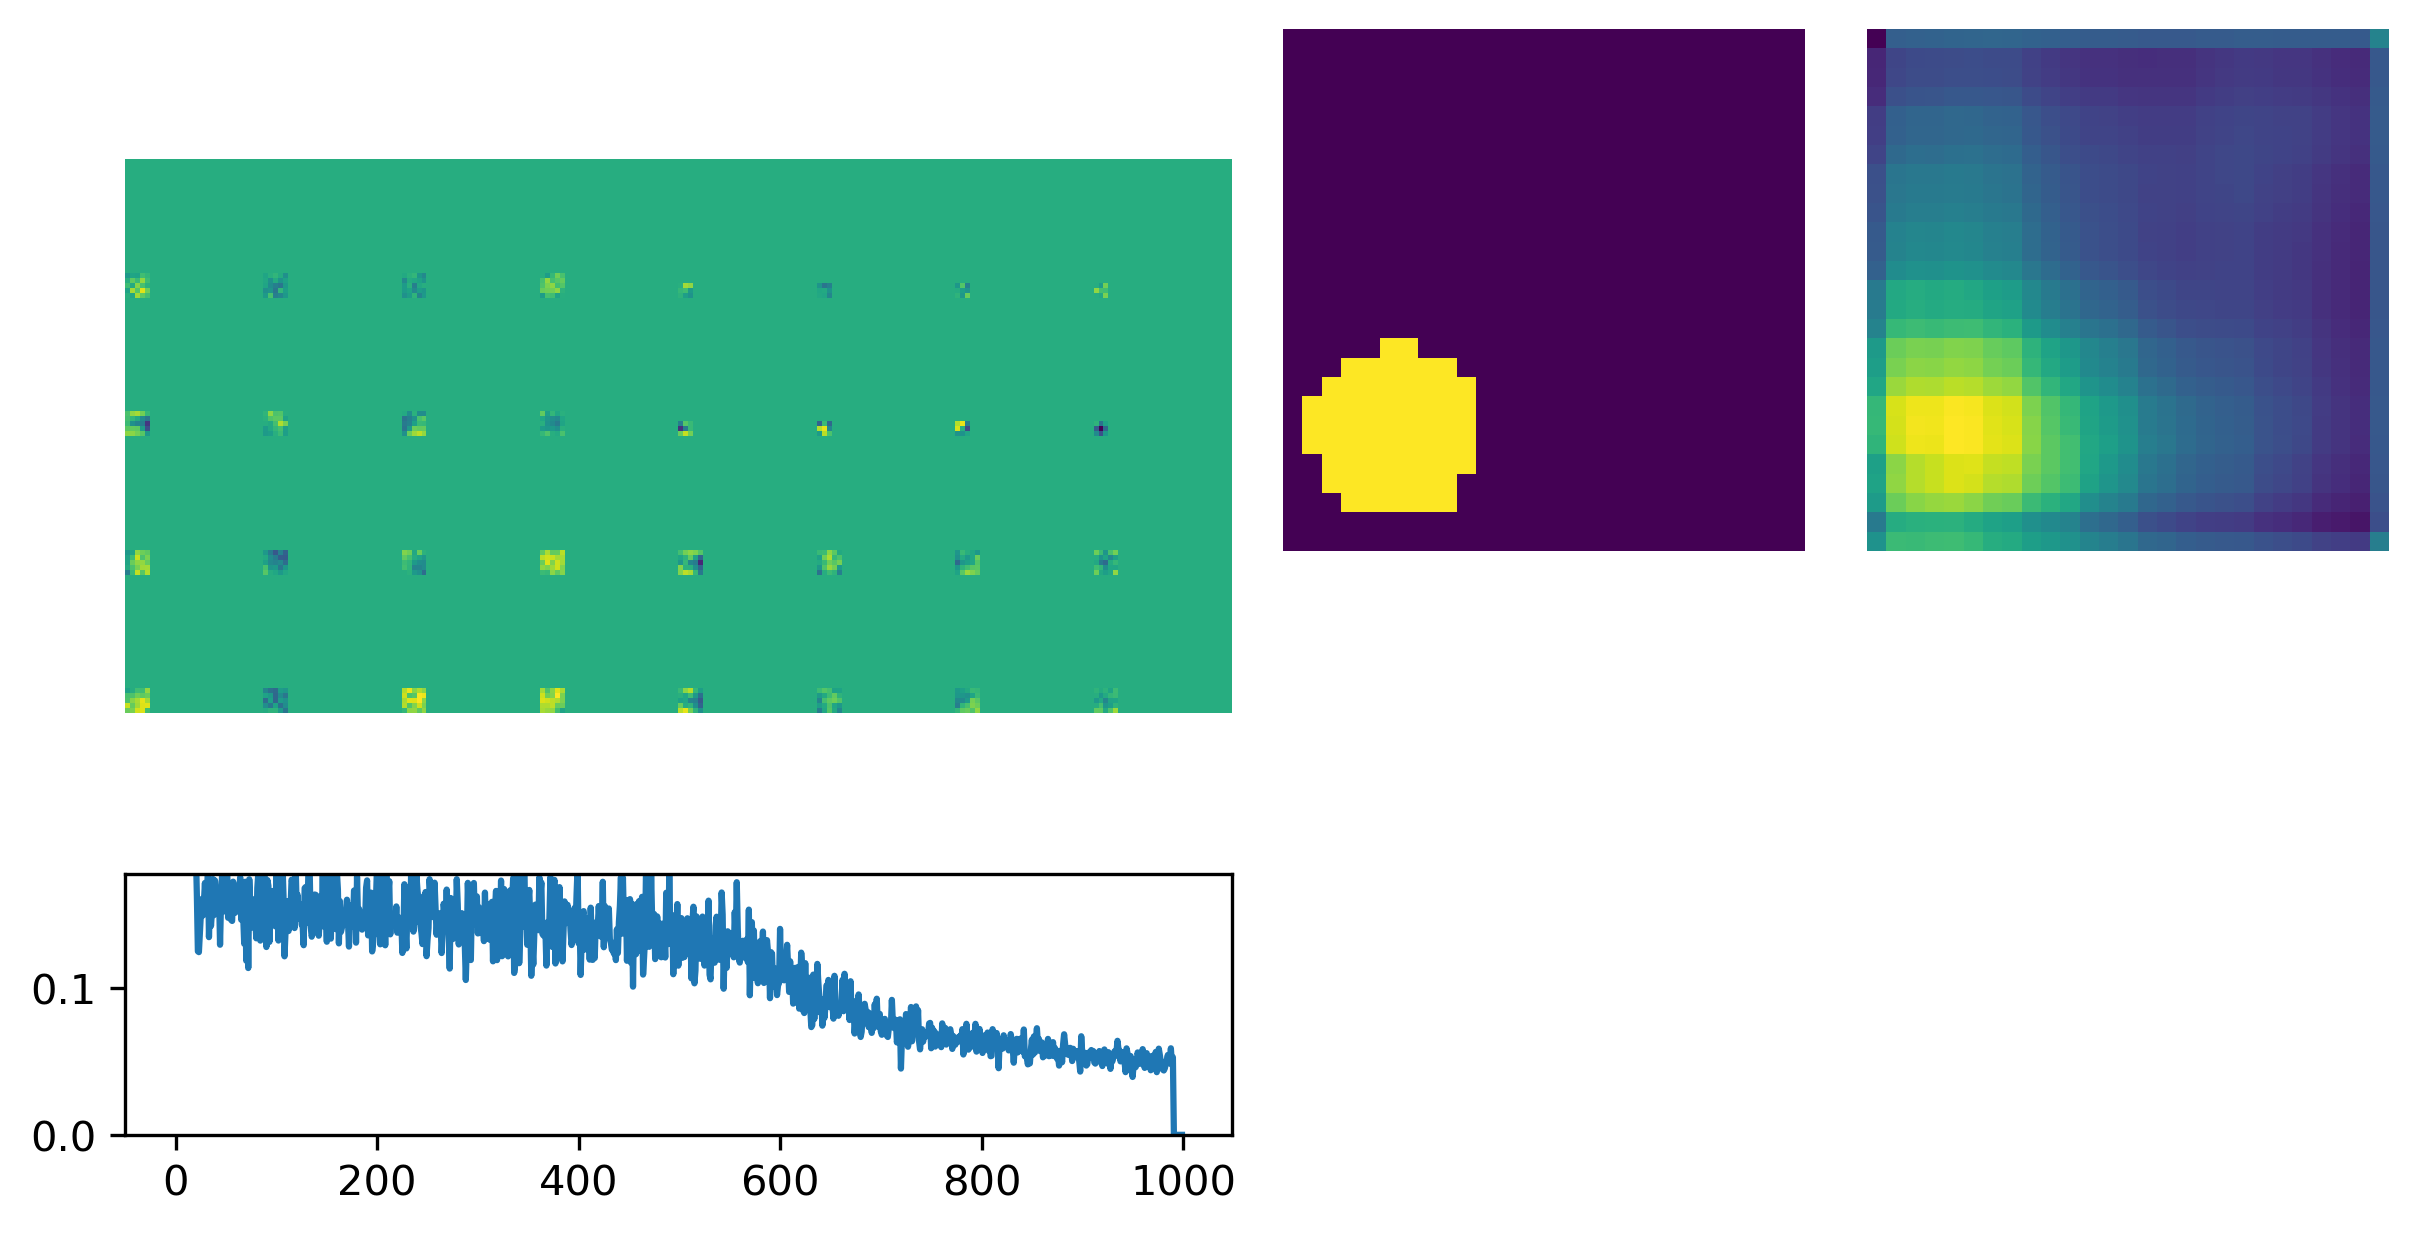

Final cost value (averaged over last 50 batches):  0.05027901485562324


In [16]:
visualize_CNN_training(Net, my_generator, 9 * 3,
                      steps = 1000, batchsize = 30,
                      visualize_nsteps = 10, 
                      plot_img_cols = 8, plot_img_rows = 4,
                      plot_img_pixels = 27, show_intermediate_layers = False)

In [17]:
print_layers(Net, y_target) # find out layer sizes for these training images!
# y_target is a global variable that is initialized by the
# training visualization routine, and it contains the last few training images.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Layer 0: 2916 neurons /  (30, 27, 27, 4)
Layer 1: 324 neurons /  (30, 9, 9, 4)
Layer 2: 324 neurons /  (30, 9, 9, 4)
Layer 3: 36 neurons /  (30, 3, 3, 4)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 81 neurons /  (30, 9, 9, 1)
Layer 6: 324 neurons /  (30, 9, 9, 4)
Layer 7: 2916 neurons /  (30, 27, 27, 4)
Layer 8: 729 neurons /  (30, 27, 27, 1)


In [18]:
Net.inputs

[<tf.Tensor 'conv2d_7_input:0' shape=(None, None, None, 1) dtype=float32>]

In [19]:
print(Net.layers)

[<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022B55DC8DC8>, <tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x0000022B55DC8F88>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022B5E5ADCC8>, <tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x0000022B56E718C8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022B56E7A0C8>, <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x0000022B56E5FE88>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022B56E7BA08>, <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x0000022B56E5FE48>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022B5BEAA348>]


In [20]:
print(Model(inputs = Net.inputs,
                outputs = [layer.output for layer in Net.layers]))

In [21]:
Net.layers

In [22]:
np.shape(Net.layers[0].get_weights()[0])

(5, 5, 1, 4)